# Chordal graphs

A graph $G$ is chordal, if it does not contain an induced cycle of length $\geq 4$. Equivalently, if every cycle $C$ of length $\geq 4$ in $G$ contains a chord.

### Recognition of chordal graphs

A *perfect elemination ordering* is an ordering $v_1, v_2, \dots, v_n$ of vertices of $G$ so that $v_i$ is *simplicial vertex* in $G[v_{i}, v_{i+1}, \dots, v_n]$, i.e., $v_i$ and neighbors after it in the ordering form a clique.

A graph $G$ is chordal if and only if it admits a perfect elimination ordering.


### Exercises

1. Implement `max_cardinality_search(G)` which returns PEO of `G` using maximal cardinality search algorithm (see [Lecture notes](http://matematika.fri.uni-lj.si/dm/discrete_mathematics.pdf), Algorithm 7.1).

2. Write function `is_chordal(G)` which checks if graph `G` is chordal. Use algorithm 7.2 from Lecture notes. See also comments in the code below.

3. Write function `color_chordal_graph(G)` which returns minimal (optimal) coloring of chordal graph `G`. See Lecture notes.

4. *Write a function `maximal_cliques_chordal(G)` which returns a list of distinct maximal cliques in a chordal graph `G`.

In [4]:
def max_cardinality_search(G):
    """
    Maximum cardinality search
    """
    pass

def is_chordal(G):
    """
    Test if graph G is chordal.

    """
    peo = max_cardinality_search(G)
    # We need to check that max_cardinality_search really returns perfect elimination ordering (PEO)
    # let peo be = [v0, v1, ... v{n-1}]
    # for i = 0 ... n-1:
    #    for vi find j > i such that vj is neighbor of vi and j is as small as possible
    #    then, for all vk which are neighbors of vi, k > j, vj and vk must be adjacent 
    pass
                
def color_chordal_graph(G):
    """
    Optimally color chordal graph G.
    """
    col = {}
    peo = max_cardinality_search(G);
    # Algorithm is greedy and efficient:
    #   go from the last to the first vertex in peo
    #   select the first available color for v (smallest not used by right neighbors)
    # Thus, for chordal graphs optimal coloring is "easy" problem!
    # ...
    # ...
    return col

def maximal_cliques_chordal(G):
    # Agorithm
    # 1. Find a perfect elimination ordering (PEO) of the graph. 
    # 2. For each vertex v create a clique formed by v and its neighbors later than v in PEO. 
    # 3. From the obtained cliques select only maximal ones.    
    pass
 

### Tests

In [5]:
def random_chordal_graph(n, kmin = 5, kmax = 10, kidmin = 2, kidmax = 4):
    """Returns a 'random' chordal graph.
    The sizes of maximal cliques are between `kmin` and `kmax`,
    the intersections of maximal cliques are between `kidmin` and `kidmax`."""
    from random import randint, sample
    
    G = Graph()
    cliques = []
    nG = 0
    
    # create cliques
    for i in range(n):
        s = randint(kmin, kmax)
        K = graphs.CompleteGraph(s)
        K.relabel(lambda w: w + nG)
        G = G.union(K)
        cliques.append(K.vertices(sort=False))
        nG += s
        
    # merge parts of cliques
    for i in range(1, n):
        j = randint(0, i - 1)
        C1 = cliques[j]
        C2 = cliques[i]
        nmin = min(len(C1), len(C2))
        k = randint(kidmin, min(kidmax, nmin - 1))
        iC1 = sample(C1, k)
        iC2 = sample(C2, k)
        id = zip(iC1, iC2)
        for (u, v) in id:
            G.merge_vertices((u, v))
            C2 = [u if x == v else x for x in C2]
        cliques[i] = C2
    return G

In [3]:
def apollonian_network(n):
    """Apollonian network is a graph formed by a process of recursively subdividing a triangle 
    into three smaller triangles. This function returns Apollonian network on n vertices, n >= 3."""
    from random import choice
    G = graphs.CycleGraph(3)
    pos = {0: [1, 0], 1: [-0.5, 0.866], 2: [-0.5, -0.866]}
    faces = [[0, 1, 2]]
    for i in range(3, n):
        f = choice(faces)
        x, y, z = f
        faces.remove(f)
        faces.extend([[x, y, i], [i, y, z], [i, z, x]])
        G.add_edges([(x, i), (y, i), (z, i)])
        xi = sum(a for (a, b) in [pos[w] for w in [x, y, z]])/3
        yi = sum(b for (a, b) in [pos[w] for w in [x, y, z]])/3
        pos[i] = (xi, yi)
    G.set_pos(pos)
    return G

In [6]:
def verify_maximal_cliques(G, cliques):
    sage = G.cliques_maximal()
    return sorted([sorted(c) for c in sage]) == sorted([sorted(c) for c in cliques])

In [9]:
G = random_chordal_graph(3)
max_cardinality_search(G), is_chordal(G)

([18, 17, 14, 13, 11, 10, 6, 5, 4, 3, 2, 1, 0], True)

In [5]:
is_chordal(graphs.CompleteGraph(4))

True

In [6]:
is_chordal(graphs.CycleGraph(4))

False

### Coloring

In [3]:
def color_graph(G, coloring, **kwargs):
    all_colors = list(colors)[10:];
    color_map = {}
    for v, c in coloring.items():
        color = all_colors[c]
        color_map.setdefault(color, []).append(v)
    return G.plot(vertex_colors=color_map, **kwargs)

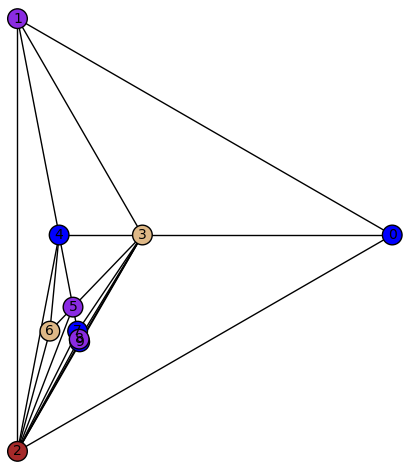

In [8]:
G = apollonian_network(10)
coloring = color_chordal_graph(G)
color_graph(G, coloring)

Apollonian network is a planar graph, therefore it should be colored with <= 4 colors

In [9]:
set(coloring.values())

{0, 1, 2, 3}

In [10]:
Verts = [11,2,12,44,12]

In [11]:
dict([(v, i) for (i, v) in enumerate(Verts)])

{11: 0, 2: 1, 12: 4, 44: 3}

In [14]:
RCG = random_chordal_graph(3)
is_chordal(RCG)
coloring = color_chordal_graph(RCG)

In [31]:
set(coloring.values())

{0, 1, 2, 3, 4, 5, 6, 7, 8}

Compare with built-in algorithm. Can be very slow!

In [32]:
RCG.coloring()

[[0, 9, 17], [1, 10, 19], [2, 20], [3], [4, 11, 21], [5], [12, 15], [13], [14]]

### Maximal cliques

In [10]:
verify_maximal_cliques(G, maximal_cliques_chordal(G))

True

In [12]:
maximal_cliques_chordal(G)

[[0, 1, 2, 3, 4, 5, 6], [3, 4, 5, 6, 10, 11], [3, 4, 13, 14, 17, 18]]

In [15]:
verify_maximal_cliques(RCG, maximal_cliques_chordal(RCG))

True

In [16]:
maximal_cliques_chordal(RCG)

[[0, 1, 2, 3, 4, 5, 6, 7, 8],
 [0, 6, 9, 10, 12, 13, 15, 16, 17],
 [12, 15, 16, 18, 19, 21, 23, 24, 25, 27]]

In [19]:
G2 = graphs.RandomTree(10)
cliques2 = maximal_cliques_chordal(G2)
verify_maximal_cliques(G2, cliques2)

True

In [21]:
G3 = Graph('[~~~~~~DOiaOC`C`aG?a@COKP?wa@wa@{P?~CONw?K???o@?@_B?@_B_?o@w?K?^')
cliques3 = maximal_cliques_chordal(G3)
verify_maximal_cliques(G3, cliques3)

True